# Movie Recommender using Keras and collaborative Filtering


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout
from keras.layers import Add, Activation, Lambda


## Add path to your dataset here
PATH = '/content/drive/My Drive/movie-recommender/ml-latest-small/ml-latest-small/'
ratings = pd.read_csv(PATH + 'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
## Reading the csv for data

movies = pd.read_csv(PATH + 'movies.csv')
movies.head()

g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]
g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]
top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


In [5]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])
n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

In [6]:
## Splitting Train Test Data

X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 2), (10084, 2), (90752,), (10084,))

In [86]:
## Defining the no of factors and train and test array

n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]


array([2. , 2. , 3.5, ..., 4. , 3. , 5. ], dtype=float32)

In [0]:
## Function to build Your Model

def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [12]:
## Train the model on the train data

model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
____________________________________________________________________________________________

In [13]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5, verbose=1, validation_data=(X_test_array, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 7s 76us/step - loss: 0.9094 - val_loss: 0.7907
Epoch 2/5
90752/90752 [==============================] - 5s 58us/step - loss: 0.7684 - val_loss: 0.7761
Epoch 3/5
90752/90752 [==============================] - 5s 59us/step - loss: 0.7325 - val_loss: 0.7817
Epoch 4/5
90752/90752 [==============================] - 5s 54us/step - loss: 0.7149 - val_loss: 0.7769
Epoch 5/5
90752/90752 [==============================] - 5s 56us/step - loss: 0.7035 - val_loss: 0.7840


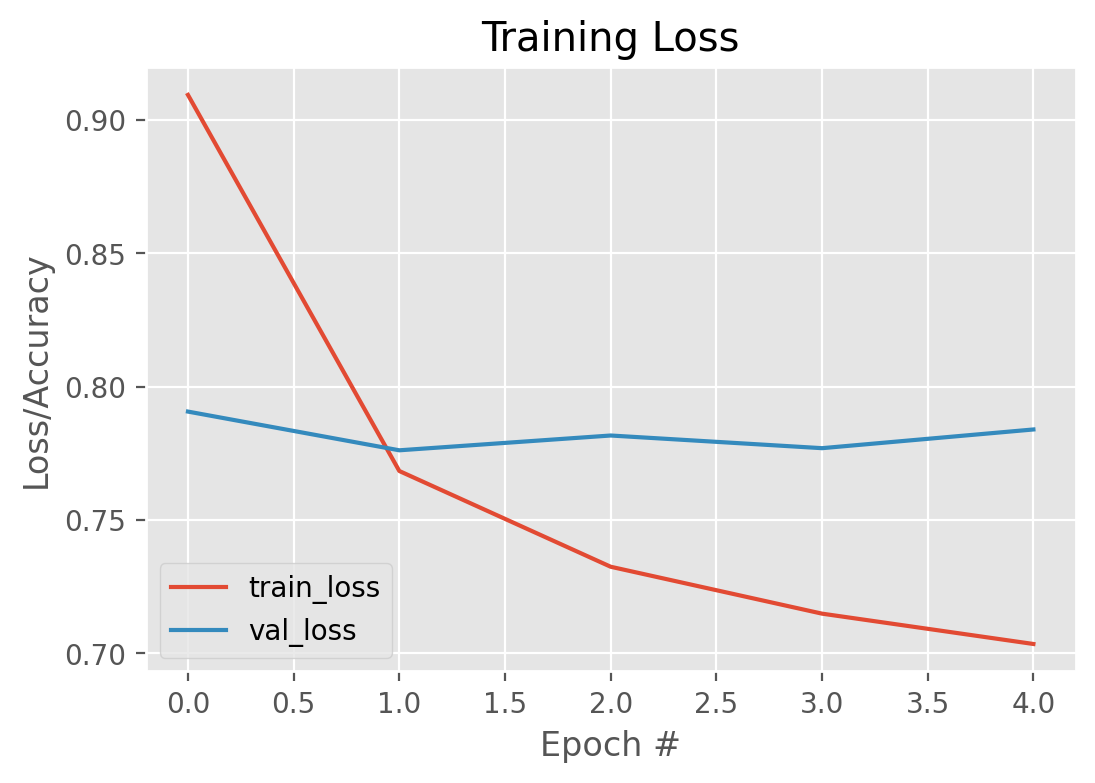

In [25]:
## Plot the summary of the training of the model created

import matplotlib.pyplot as plt
N = 5
plt.style.use("ggplot")
plt.figure(dpi=200)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


In [0]:
## Add path to save your model

model.save('/content/drive/My Drive/movie-recommender/recommender.h5') 

In [0]:
## Function that predicts the rating of a movie x by a user y

def predict(user_id, movie_id):
  input = [[user_id-1],[movie_id-1]]
  val = model.predict(input)[0][0]
  rating_pred = round(val,0)
  return rating_pred

In [83]:
## Function that first estimates ratings for all movies that the user should give based on his past ratings and the returns the movies along with the estimated ratings in the sorted order

def recommend(user_id):
  rate = []
  for i in range(1,n_movies+1):
    rate.append([i,predict(user_id,i)])
  
  rate = sorted(rate, key = lambda x : x[1], reverse = True)
  return rate
r = recommend(611)
print(r)

[[278, 5.0], [688, 5.0], [883, 5.0], [918, 5.0], [1589, 5.0], [2374, 5.0], [2423, 5.0], [2580, 5.0], [4391, 5.0], [5568, 5.0], [5833, 5.0], [7585, 5.0], [9284, 5.0], [9601, 5.0], [1, 4.0], [6, 4.0], [14, 4.0], [16, 4.0], [17, 4.0], [18, 4.0], [25, 4.0], [28, 4.0], [29, 4.0], [30, 4.0], [32, 4.0], [33, 4.0], [34, 4.0], [37, 4.0], [38, 4.0], [44, 4.0], [47, 4.0], [49, 4.0], [51, 4.0], [53, 4.0], [55, 4.0], [62, 4.0], [65, 4.0], [67, 4.0], [70, 4.0], [73, 4.0], [77, 4.0], [78, 4.0], [84, 4.0], [86, 4.0], [87, 4.0], [88, 4.0], [90, 4.0], [95, 4.0], [97, 4.0], [98, 4.0], [99, 4.0], [102, 4.0], [108, 4.0], [109, 4.0], [121, 4.0], [122, 4.0], [124, 4.0], [125, 4.0], [128, 4.0], [130, 4.0], [136, 4.0], [144, 4.0], [148, 4.0], [149, 4.0], [153, 4.0], [159, 4.0], [165, 4.0], [169, 4.0], [180, 4.0], [182, 4.0], [183, 4.0], [184, 4.0], [191, 4.0], [199, 4.0], [200, 4.0], [202, 4.0], [208, 4.0], [209, 4.0], [211, 4.0], [212, 4.0], [214, 4.0], [225, 4.0], [226, 4.0], [227, 4.0], [228, 4.0], [229, 4.

In [0]:
## Function that fit the model with the new ratings entered by a user

def rate(user_id,movs,rate):
  X = [user_id for i in movs]
  X_add = [X, movs]
  Y_add = np.array(r)
  model.fit(x=X_add, y=Y_add, batch_size=64, epochs=5, verbose=1, validation_data=(X_test_array, y_test))


In [0]:
## Function that first rates the movies then updated the model and then finally recommends top 10 movies based on your liking

def give_movies(user,movies_rated,ratings_of_user):

  ## Instead of using movies_rated and ratings_of_user REDIRECT TO TAKE INPUT OF USER FOR DIFFERENT MOVIES and RETURN movie_id and ratings in two arrays here
  mov = []
  rate(user, movies_rated, ratings_of_user)
  r = recommend(user)
  k = 10
  for i in r[:k]:
    mov.append(movies.loc[i[0]-1]['title'])
    print(movies.loc[i[0]-1]['title'],movies.loc[i[0]-1]['genres'])
  return mov

In [128]:
## Sample Data to test the model

user = 611
movies_rated = [1,2,3,4,7,18,19,6,8,9,10]
ratings_of_user = [4,4,5,5,5,5,5,1,2,2,1]

print(give_movies(user,movies_rated,ratings_of_user))

Train on 11 samples, validate on 10084 samples
Epoch 1/5
11/11 [==============================] - 0s 21ms/step - loss: 1.0390 - val_loss: 0.8456
Epoch 2/5
11/11 [==============================] - 0s 20ms/step - loss: 0.8679 - val_loss: 0.8490
Epoch 3/5
11/11 [==============================] - 0s 20ms/step - loss: 1.1744 - val_loss: 0.8527
Epoch 4/5
11/11 [==============================] - 0s 21ms/step - loss: 1.3291 - val_loss: 0.8567
Epoch 5/5
11/11 [==============================] - 0s 21ms/step - loss: 0.9308 - val_loss: 0.8609
Lamerica (1994) Adventure|Drama
Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
Shawshank Redemption, The (1994) Crime|Drama
Vanya on 42nd Street (1994) Drama
Underground (1995) Comedy|Drama|War
World of Apu, The (Apur Sansar) (1959) Drama
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) Comedy|War
Godfather, The (1972) Crime|Drama
Philadelphia Story, The (1940) Comedy|Drama|Romance
It Happened One Night (1934) Comedy|Romance
['Lame